# Simlep influence plots of IBM/non-IBM users
Author: Daheng Wang  
Last modified: 2017-05-08

# Roadmap
1. Calculate simple influece measurement
2. Plot influences of IBM/non-IBM users

# Steps

## Initialization

In [1]:
# Data analysis modules: pandas, matplotlib, numpy, and etc.
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # render double resolution plot output for Retina screens 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Standard modules, MongoDB modules
import os, sys, json, datetime, pickle, multiprocessing, logging
from pprint import pprint

import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING

# Custom tool modules
import mongodb  # module for setting up connection with (local) MongoDB database
import multiprocessing_workers  # module for splitting workloads between processes
import utilities  # module for various custom utility functions
from config import * # import all global configuration variables

## Query database and build pickle

We first calculate a simple influence measurement based on 
1. the 'retweet_count' field of tweet
2. the 'followers_count' field of user
The basic idea is we are looking for "popular users who can motivate others to engage in discussion". We use the 'retweet_count' to represent the popularity of a user, and use the 'followers_count' to represent the engagement level affected by the user.

We define: simple_influence = sum of retweet_count over a user / followers_count of user
At the same time, we differentiate between native/quote/reply tweets.

_Step 1_ Build pickles.

In [2]:
simple_influence_all_pkl = os.path.join(TMP_DIR, 'simple_influence_all.lst.pkl') # pickle for all tweets grouped by user id
simple_influence_quote_pkl = os.path.join(TMP_DIR, 'simple_influence_quote.lst.pkl') # pickle for only quote tweets grouped by user id
simple_influence_reply_pkl = os.path.join(TMP_DIR, 'simple_influence_reply.lst.pkl') # pickle for only reply tweets grouped by user id
simple_influence_native_pkl = os.path.join(TMP_DIR, 'simple_influence_native.lst.pkl') # pickle for only native tweets grouped by user id

In [3]:
%%time
# 1. pickle for all tweets (non retweet tweets) grouped by user id
if not os.path.exists(simple_influence_all_pkl):
    print('Building pickle from database...')
    data_lst = []
    
    # query on all tweets
    match_dict = {'$match': {'retweeted_status': {'$exists': False}}}
    
    group_dict = {'$group': {'_id': '$user.id', # user's id
                             'followers_count': {'$first': '$user.followers_count'}, # number of followers the user has
                             'all_tweets_num': {'$sum': 1}, # total number of all tweets belongs to the user
                             'all_tweets_total_retweet_count': {'$sum': '$retweet_count'} # sum of retweet counts of all tweets belong to the user
                             }}
    project_dict = {'$project': {'_id': 0,
                                'user_id': '$_id',
                                'followers_count': 1,
                                'all_tweets_num': 1,
                                'all_tweets_total_retweet_count': 1}}
    
    
    ppl_lst = [match_dict, group_dict, project_dict]
    print('Aggreating on collection "{}"'.format(UPDATED_COL))
    updated_col = mongodb.initialize(db_name=DB_NAME, collection_name=UPDATED_COL)
    cursor = updated_col.aggregate(pipeline=ppl_lst,
                                   allowDiskUse=True) # Exceeded memory limit for $group, but didn't allow external sort. Pass allowDiskUse:true to opt in.
    for doc in cursor:
        data_lst.append(doc)
        
    with open(simple_influence_all_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')
else:
    print('Pickled data found')

Pickled data found
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 629 µs


In [4]:
%%time
# 2. pickle for all quote tweets grouped by user id
if not os.path.exists(simple_influence_quote_pkl):
    print('Building pickle from database...')
    data_lst = []
    
    # query only quote tweets
    match_dict = {'$match': {'retweeted_status': {'$exists': False},
                             'quoted_status': {'$exists': True}}}
    
    group_dict = {'$group': {'_id': '$user.id', # user's id
                             'quote_tweets_num': {'$sum': 1}, # total number of quote tweets belongs to the user
                             'quote_tweets_total_retweet_count': {'$sum': '$retweet_count'} # sum of retweet counts of all quote tweets belong to the user
                             }}
    project_dict = {'$project': {'_id': 0,
                                'user_id': '$_id',
                                'quote_tweets_num': 1,
                                'quote_tweets_total_retweet_count': 1}}
    
    
    ppl_lst = [match_dict, group_dict, project_dict]
    print('Aggreating on collection "{}"'.format(UPDATED_COL))
    updated_col = mongodb.initialize(db_name=DB_NAME, collection_name=UPDATED_COL)
    cursor = updated_col.aggregate(pipeline=ppl_lst,
                                   allowDiskUse=True) # Exceeded memory limit for $group, but didn't allow external sort. Pass allowDiskUse:true to opt in.
    for doc in cursor:
        data_lst.append(doc)
        
    with open(simple_influence_quote_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')
else:
    print('Pickled data found')

Pickled data found
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 236 µs


In [5]:
%%time
# 3. pickle for all reply tweets grouped by user id
if not os.path.exists(simple_influence_reply_pkl):
    print('Building pickle from database...')
    data_lst = []
    
    # query only reply tweets
    match_dict = {'$match': {'retweeted_status': {'$exists': False},
                             'in_reply_to_status_id': {'$ne': None}}}
    
    group_dict = {'$group': {'_id': '$user.id', # user's id
                             'reply_tweets_num': {'$sum': 1}, # total number of reply tweets belongs to the user
                             'reply_tweets_total_retweet_count': {'$sum': '$retweet_count'} # sum of retweet counts of all reply tweets belong to the user
                             }}
    project_dict = {'$project': {'_id': 0,
                                'user_id': '$_id',
                                'reply_tweets_num': 1,
                                'reply_tweets_total_retweet_count': 1}}
    
    
    ppl_lst = [match_dict, group_dict, project_dict]
    print('Aggreating on collection "{}"'.format(UPDATED_COL))
    updated_col = mongodb.initialize(db_name=DB_NAME, collection_name=UPDATED_COL)
    cursor = updated_col.aggregate(pipeline=ppl_lst,
                                   allowDiskUse=True) # Exceeded memory limit for $group, but didn't allow external sort. Pass allowDiskUse:true to opt in.
    for doc in cursor:
        data_lst.append(doc)
        
    with open(simple_influence_reply_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')
else:
    print('Pickled data found')

Pickled data found
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 289 µs


In [6]:
%%time
# 4. pickle for all native tweets grouped by user id
if not os.path.exists(simple_influence_native_pkl):
    print('Building pickle from database...')
    data_lst = []
    
    # query only retweet tweets
    match_dict = {'$match': {'retweeted_status': {'$exists': False}, # not a retweet
                             'quoted_status': {'$exists': False}, # not a quote
                             'in_reply_to_status_id': {'$eq': None} # not a reply
                            }}
    group_dict = {'$group': {'_id': '$user.id', # user's id
                             'native_tweets_num': {'$sum': 1}, # total number of native tweets belongs to the user
                             'native_tweets_total_retweet_count': {'$sum': '$retweet_count'} # sum of retweet counts of all native tweets belong to the user
                             }}
    project_dict = {'$project': {'_id': 0,
                                'user_id': '$_id',
                                'native_tweets_num': 1,
                                'native_tweets_total_retweet_count': 1}}
    
    
    ppl_lst = [match_dict, group_dict, project_dict]
    print('Aggreating on collection "{}"'.format(UPDATED_COL))
    updated_col = mongodb.initialize(db_name=DB_NAME, collection_name=UPDATED_COL)
    cursor = updated_col.aggregate(pipeline=ppl_lst,
                                   allowDiskUse=True) # Exceeded memory limit for $group, but didn't allow external sort. Pass allowDiskUse:true to opt in.
    for doc in cursor:
        data_lst.append(doc)
        
    with open(simple_influence_native_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')
else:
    print('Pickled data found')

Pickled data found
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 329 µs


_Step 2_ Read in tmp pickles, pass to dfs, merge dfs, and pickle result large df to data dir.

In [7]:
"""
This section generates a global pickle file for aggregated (different types of) tweets number and (different types of) retweets count on users.
Register SIMPLE_INFLUENCE_PKL = os.path.join(DATA_DIR, 'simple_influence.df.pkl').
"""
if 0 == 1:
    data_lst = []
    with open(simple_influence_all_pkl, 'rb') as f:
        data_lst = pickle.load(f)
    column_names = ['user_id', 'followers_count', 'all_tweets_num', 'all_tweets_total_retweet_count']
    df_all = pd.DataFrame(data=data_lst,
                          columns=column_names, # explicitly pass in names of columns
                          dtype=int)
    del data_lst
    
    data_lst = []
    with open(simple_influence_quote_pkl, 'rb') as f:
        data_lst = pickle.load(f)
    column_names = ['user_id', 'quote_tweets_num', 'quote_tweets_total_retweet_count']
    df_quote = pd.DataFrame(data=data_lst,
                          columns=column_names, # explicitly pass in names of columns
                          dtype=int)
    del data_lst
    
    data_lst = []
    with open(simple_influence_reply_pkl, 'rb') as f:
        data_lst = pickle.load(f)
    column_names = ['user_id', 'reply_tweets_num', 'reply_tweets_total_retweet_count']
    df_reply = pd.DataFrame(data=data_lst,
                          columns=column_names, # explicitly pass in names of columns
                          dtype=int)
    del data_lst
    
    data_lst = []
    with open(simple_influence_native_pkl, 'rb') as f:
        data_lst = pickle.load(f)
    column_names = ['user_id', 'native_tweets_num', 'native_tweets_total_retweet_count']
    df_native = pd.DataFrame(data=data_lst,
                          columns=column_names, # explicitly pass in names of columns
                          dtype=int)
    del data_lst
    
    df = pd.merge(df_all, df_quote, on='user_id', how='left')
    df = pd.merge(df, df_reply, on='user_id', how='left')
    df = pd.merge(df, df_native, on='user_id', how='left')

    column_names = {'user_id': 'uid',
                    'followers_count': 'fo',
                    'all_tweets_num': 'a_n',
                    'all_tweets_total_retweet_count': 'a_trc',
                    'quote_tweets_num': 'q_n',
                    'quote_tweets_total_retweet_count': 'q_trc',
                    'reply_tweets_num': 'p_n',
                    'reply_tweets_total_retweet_count': 'p_trc',
                    'native_tweets_num': 'n_n',
                    'native_tweets_total_retweet_count': 'n_trc'
                   }
    df = df.rename(columns=column_names)
    
    # use pandas built-in pickle function
    df.to_pickle(SIMPLE_INFLUENCE_PKL)

## Read in pickled df, compute simple influence, and plot

In [2]:
if 1 == 1:
    df = pd.read_pickle(SIMPLE_INFLUENCE_PKL)

In [3]:
df.shape

(356548, 10)

In [10]:
# clean and preparations
df = df.fillna(0)
# since we plot influence on log scale, we need to eliminate all 0 values.

# clean all users with 0 followers
# df['fo'] += 1

# df['r_trc'] += 1
# df['q_trc'] += 1
# df['p_trc'] += 1
# df['n_trc'] += 1

# df['a_trc'] += 4

# fo_cond = df['fo'] > 1
# a_n_cond = df['a_n'] > 1
# df = df[fo_cond & a_n_cond]

In [4]:
df

,uid,fo,a_n,a_trc,q_n,q_trc,p_n,p_trc,n_n,n_trc
0,761864635,565,1,4,NaN,NaN,NaN,NaN,1.0,4.0
1,193829099,168,1,0,NaN,NaN,NaN,NaN,1.0,0.0
2,837983391869853697,394,1,1,NaN,NaN,NaN,NaN,1.0,1.0
3,711000942,220,1,0,1.0,0.0,NaN,NaN,NaN,NaN
4,1167287023,50,1,0,NaN,NaN,1.0,0.0,NaN,NaN
5,851228970628640768,0,1,0,NaN,NaN,1.0,0.0,NaN,NaN
6,4419727995,1272,1,0,NaN,NaN,NaN,NaN,1.0,0.0
7,8908802,253,1,0,1.0,0.0,NaN,NaN,NaN,NaN
8,769388814766747648,243,1,0,NaN,NaN,NaN,NaN,1.0,0.0
9,82652901,894200,1,5,NaN,NaN,NaN,NaN,1.0,5.0


In [5]:
df.describe()

,uid,fo,a_n,a_trc,q_n,q_trc,p_n,p_trc,n_n,n_trc
count,3.565480e+05,3.565480e+05,356548.000000,356548.000000,71507.000000,71507.000000,23674.000000,23674.000000,292694.000000,292694.000000
mean,1.121498e+17,5.607520e+03,7.231001,6.906921,1.981135,2.014013,1.896046,3.213483,8.178490,7.673218
std,2.749137e+17,1.474430e+05,168.656385,278.678473,18.722289,26.833162,31.830428,186.033921,185.467946,294.226872
min,5.900000e+01,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,8.637711e+07,1.090000e+02,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,4.725905e+08,3.990000e+02,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,2.921196e+09,1.369000e+03,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,2.000000
max,8.512290e+17,3.527031e+07,47949.000000,94147.000000,3063.000000,2925.000000,4774.000000,27398.000000,47949.000000,93856.000000


## Plot simple influence of IBM/non-IBM users

In [6]:
if 1 == 1:
    m1_ibm_user_ids_lst = []
    m2_ibm_user_ids_lst = []
    
    if not m1_ibm_user_ids_lst:
        with open(M1_IBM_USER_IDS_PKL, 'rb') as f:
            m1_ibm_user_ids_lst = pickle.load(f)
            
    if not m2_ibm_user_ids_lst:
        with open(M2_IBM_USER_IDS_PKL, 'rb') as f:
            m2_ibm_user_ids_lst = pickle.load(f)
            
    m1_ibm_user_ids_set = set(m1_ibm_user_ids_lst)
    m2_ibm_user_ids_set = set(m2_ibm_user_ids_lst)
            
    m1_ibm_cond = df['uid'].isin(m1_ibm_user_ids_set)
    df_m1_ibm = df[m1_ibm_cond]
    
    m1_nonibm_cond = ~df['uid'].isin(m1_ibm_user_ids_set)
    df_m1_nonibm = df[m1_nonibm_cond]
    
    m2_ibm_cond = df['uid'].isin(m2_ibm_user_ids_set)
    df_m2_ibm = df[m2_ibm_cond]
    
    m2_nonibm_cond = ~df['uid'].isin(m2_ibm_user_ids_set)
    df_m2_nonibm = df[m2_nonibm_cond]

In [8]:
df_m1_ibm[df_m1_ibm['fo'] * df_m1_ibm['a_n'] > 1]

,uid,fo,a_n,a_trc,q_n,q_trc,p_n,p_trc,n_n,n_trc
0,761864635,565,1,4,NaN,NaN,NaN,NaN,1.0,4.0
488,845018878585389056,43,1,0,NaN,NaN,NaN,NaN,1.0,0.0
537,25267700,80,1,0,1.0,0.0,NaN,NaN,NaN,NaN
858,709734583869247490,126,1,0,NaN,NaN,NaN,NaN,1.0,0.0
959,868118912,42,1,0,1.0,0.0,NaN,NaN,NaN,NaN
1026,837651184282402816,28,1,0,1.0,0.0,NaN,NaN,NaN,NaN
1066,785236,524,2,1,NaN,NaN,NaN,NaN,2.0,1.0
1188,17180806,4077,1,0,NaN,NaN,NaN,NaN,1.0,0.0
1341,397645003,96,1,0,NaN,NaN,NaN,NaN,1.0,0.0
1514,362092306,154,1,0,NaN,NaN,NaN,NaN,1.0,0.0


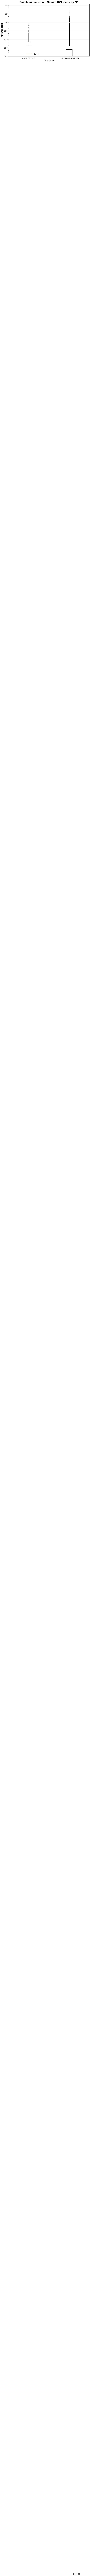

In [17]:
simple_influence_m1_fig = os.path.join(FIG_DIR, 'simple_influence_m1.png')
if 1 == 1:
    '''
    Prepare data
    '''
    # IBM users
    m1_ibm_norm_s = df_m1_ibm['fo'] * df_m1_ibm['a_n']
    m1_ibm_norm_s = m1_ibm_norm_s.replace(to_replace=0, value=1) # clean 0 values since its denominator
    m1_ibm_simple_influence = df_m1_ibm['a_trc'] / m1_ibm_norm_s
    
    # non-IBM users
    m1_nonibm_norm_s = df_m1_nonibm['fo'] * df_m1_nonibm['a_n']
    m1_nonibm_norm_s = m1_nonibm_norm_s.replace(to_replace=0, value=1) # clean 0 values since its denominator
    m1_nonibm_simple_influence = df_m1_nonibm['a_trc'] / m1_nonibm_norm_s
    
    data = [m1_ibm_simple_influence, m1_nonibm_simple_influence]
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    bp = plt.boxplot(data, notch=False, sym='k+', vert=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)
    
    ax.set_xticklabels(['4,782 IBM users', '351,766 non-IBM users'])
    
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title('Simple influence of IBM/non-IBM users by M1', fontdict=title_fontdict)
    
    label_fontdict = {'size': 'large'}
    ax.set_xlabel('User types', fontdict=label_fontdict)
    ax.set_ylabel('Influence score', fontdict=label_fontdict)
    ax.set_yscale('log')
    
#     ax.set_autoscaley_on(True)
#     ax.set_ylim([float(1e-10), 1])
    
    # add a horizontal grid to the plot, but make it very light in color
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    # add median value text to the median line
    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # right point of median line
        # overlay median value
        ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')
    
    '''
    Save figure
    '''
    plt.savefig(simple_influence_m1_fig, dpi=200)

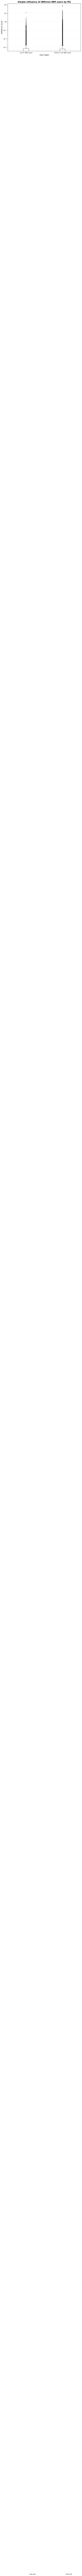

In [18]:
simple_influence_m2_fig = os.path.join(FIG_DIR, 'simple_influence_m2.png')
if 1 == 1:
    '''
    Prepare data
    '''
    # IBM users
    m2_ibm_norm_s = df_m2_ibm['fo'] * df_m2_ibm['a_n']
    m2_ibm_norm_s = m2_ibm_norm_s.replace(to_replace=0, value=1) # clean 0 values since its denominator
    m2_ibm_simple_influence = df_m2_ibm['a_trc'] / m2_ibm_norm_s
    
    # non-IBM users
    m2_nonibm_norm_s = df_m2_nonibm['fo'] * df_m2_nonibm['a_n']
    m2_nonibm_norm_s = m2_nonibm_norm_s.replace(to_replace=0, value=1) # clean 0 values since its denominator
    m2_nonibm_simple_influence = df_m2_nonibm['a_trc'] / m2_nonibm_norm_s

    data = [m2_ibm_simple_influence, m2_nonibm_simple_influence]
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    bp = plt.boxplot(data, notch=False, sym='k+', vert=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)
    
    ax.set_xticklabels(['27,077 IBM users', '329,471 non-IBM users'])
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title('Simple influence of IBM/non-IBM users by M2', fontdict=title_fontdict)
    
    label_fontdict = {'size': 'large'}
    ax.set_xlabel('User types', fontdict=label_fontdict)
    ax.set_ylabel('Influence score', fontdict=label_fontdict)
    ax.set_yscale('log')
    
#     ax.set_autoscaley_on(True)
#     ax.set_ylim([float(1e-50), 1e-2])

    # add a horizontal grid to the plot, but make it very light in color
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    # add median value text to the median line
    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # right point of median line
        # overlay median value
        ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')

    '''
    Save figure
    '''
    plt.savefig(simple_influence_m2_fig, dpi=200)

# Notes

Issues:
1. Both the distribution of 'retweet_count' and the distribution 'followers_count' are high skewed.
2. There are other information useful: 'favorite_count' of tweet...
3. Do not differentiate between influence on IBM users or influence on non-IBM users.